# 최종

In [1]:
# srgan 가상환경으로 돌림(tf=2.8, tf_gpu=2.8, keras=2.8)

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from data_augmentation import *
from model import *

from tensorflow import keras
from keras import layers


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
epochs = 100

In [3]:
div2k_data = tfds.image.Div2k(config="bicubic_x4",data_dir = "./image_dataset")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True) # as_supervised: 데이터셋을 (입력, 레이블) 쌍으로 반환할지 여부를 결정. True이면 쌍으로, False이면 입력 데이터만 반환
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()


데이터 증강(Flip, Rotate 등)

In [4]:
train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

In [5]:
lowres, highres = next(iter(train_ds))

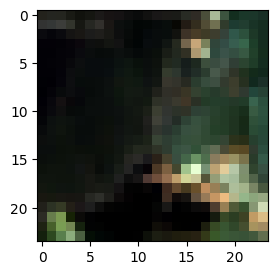

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(lowres[1]) # 저해상도 데이터셋

In [67]:
# lowres 배열에서 NumPy 배열로 데이터를 추출
lowres_numpy = lowres.numpy()

# plt.imsave('./test_image/test_image1_low.png',lowres_numpy[1])

TensorShape([96, 96, 3])

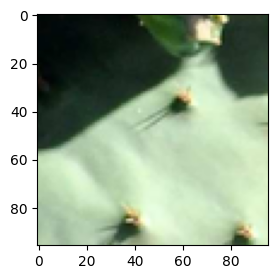

In [68]:
plt.figure(figsize=(3, 3))
plt.imshow(highres[1]) # 고해상도 데이터셋
highres[1].shape

In [69]:
# lowres 배열에서 NumPy 배열로 데이터를 추출
highres_numpy = highres.numpy()

# plt.imsave('./test_image/test_image1_high.png',highres_numpy[1])

In [8]:
model = make_model(num_filters=64, num_of_residual_blocks=16)

In [9]:
filename = 'EDSR_epoch{}.h5'.format(epochs)

optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])

callbacks = [ 
    # tensorboardm
    # tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True),
    
    # 개선된 validation score를 도출해낼 때마다 weight를 .h5타입으로 중간 저장
    # 모델을 저장할 때의 파라미터를 조정하는 것
    ModelCheckpoint(filepath=filename,
                        monitor='val_loss', # 모델을 저장할 때, 기준이 되는 값을 지정. 예를 들어, validation set의 loss가 가장 작을 때 저장하고 싶으면 'val_loss'를 입력
                        save_weights_only=False, # True인 경우, 모델의 weights만 저장됨. False인 경우, 모델 레이어 및 weights 모두 저장됨.
                        verbose=1,  # 1일 경우 모델이 저장 될 때, '저장되었습니다' 라고 화면에 표시되고, 0일 경우 화면에 표시되는 것 없이 그냥 바로 모델이 저장됨.
                        save_best_only=True,  # True 인 경우, monitor 되고 있는 값을 기준으로 가장 좋은 값으로 모델이 저장됨. False인 경우, 매 에폭마다 모델이 filepath{epoch}으로 저장된다. (model0, model1, model2....)
                        mode='auto')  # auto means automatically find the best
                        ]

# Training for more epochs will improve results
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
198/200 [============================>.] - ETA: 0s - loss: 27.1481 - PSNR: 19.7539
Epoch 1: val_loss improved from inf to 14.09274, saving model to EDSR_epoch100.h5
200/200 [==============================] - 33s 70ms/step - loss: 26.9919 - PSNR: 19.7788 - val_loss: 14.0927 - val_PSNR: 23.4438
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 12.7784 - PSNR: 24.9958
Epoch 2: val_loss improved from 14.09274 to 11.82472, saving model to EDSR_epoch100.h5
200/200 [==============================] - 5s 25ms/step - loss: 12.7784 - PSNR: 24.9958 - val_loss: 11.8247 - val_PSNR: 25.8385
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 11.0294 - PSNR: 26.8362
Epoch 3: val_loss improved from 11.82472 to 10.17933, saving model to EDSR_epoch100.h5
200/200 [==============================] - 6s 32ms/step - loss: 11.0294 - PSNR: 26.8362 - val_loss: 10.1793 - val_PSNR: 27.0943
Epoch 4/100
199/200 [============================>.] - ETA: 0s - loss: 9.9

### Bicubic과 FSRCNN과 EDSR 비교

In [7]:
train_img = np.asarray(Image.open('./test_image/test_image1_low.png'))
train_img_rgb = train_img[:, :, :3] 
train_img_rgb.shape

(24, 24, 3)

In [8]:
bicubic_img = cv2.resize(train_img_rgb,(96,96), interpolation=cv2.INTER_CUBIC)
bicubic_img.shape

(96, 96, 3)

In [9]:
high_resolution_img = np.asarray(Image.open('./test_image/test_image1_high.png'))
high_resolution_img = high_resolution_img[:, :, :3] 
high_resolution_img.shape

(96, 96, 3)

In [10]:
edsr_model = keras.models.load_model('EDSR_epoch100.h5',custom_objects={'EDSRModel': EDSRModel, 'PSNR': PSNR})
# fsrcnn_model = keras.models.load_model('FSRCNN.h5')
# predict = model.predict(train_img) # 훈련할거 넣기

In [11]:
edsr_predict = edsr_model.predict(train_img_rgb)

(96, 96, 3)

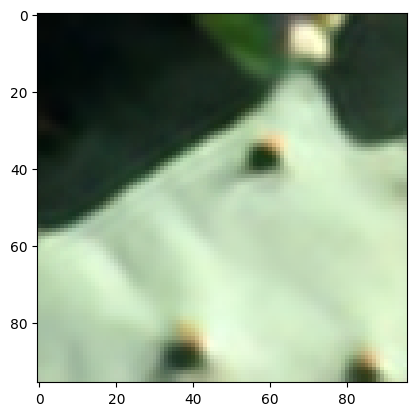

In [12]:
plt.imshow(edsr_predict)
edsr_predict.shape

(96, 96, 3)

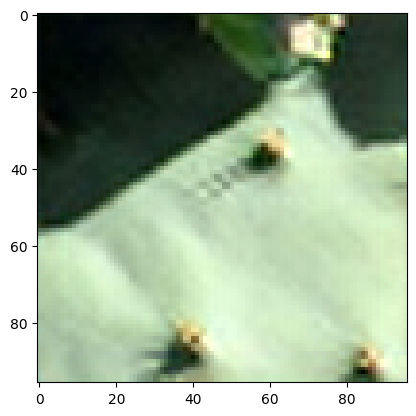

In [13]:
fsrcnn_img = Image.open('./fsrcnn_cactus.png')
fsrcnn_img = np.array(fsrcnn_img)
fsrcnn_img = fsrcnn_img[:,:,:3]
plt.imshow(fsrcnn_img)
fsrcnn_img.shape

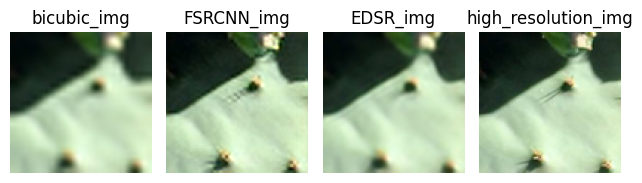

In [14]:
# 1행 2열의 서브플롯을 생성합니다.
fig, axes = plt.subplots(1, 4)

# 첫 번째 서브플롯에 이미지를 표시합니다.
axes[0].imshow(bicubic_img)
axes[0].set_title('bicubic_img')

# 두 번째 서브플롯에 이미지를 표시합니다.
axes[1].imshow(fsrcnn_img)
axes[1].set_title('FSRCNN_img')

# 두 번째 서브플롯에 이미지를 표시합니다.
axes[2].imshow(edsr_predict)
axes[2].set_title('EDSR_img')

# 세 번째 서브플롯에 이미지를 표시합니다.
axes[3].imshow(high_resolution_img)
axes[3].set_title('high_resolution_img')

# 각 이미지의 축을 숨깁니다.
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

# 서브플롯 간 간격을 조절합니다.
plt.tight_layout()

# 이미지를 표시합니다.
plt.show()

In [15]:
fsrcnn_img.shape

(96, 96, 3)

In [16]:
print(PSNR(high_resolution_img,bicubic_img))
print(PSNR(high_resolution_img,fsrcnn_img))
print(PSNR(high_resolution_img,edsr_predict))

34.048783172790095
35.81968514167175
35.63545849895799


In [17]:
print(SSIM(high_resolution_img,bicubic_img))
print(SSIM(high_resolution_img,fsrcnn_img))
print(SSIM(high_resolution_img,edsr_predict))

0.9938852113648797
0.9973553596783119
0.9962950530932794
